In [89]:
import pandas as pd 
import numpy as np 
import yfinance as yf
import matplotlib.pyplot as plt 
import seaborn as sns; sns.set()

In [90]:
data = yf.download(["AAPL", "GOOG", "BAS.DE", "BMW.DE", "RWE.DE", "DBK.DE"], start = "2010-01-01", end = "2020-12-31")

[*********************100%***********************]  6 of 6 completed


In [91]:
data.head()

Adj Close                                                         \
                AAPL     BAS.DE     BMW.DE     DBK.DE       GOOG     RWE.DE   
Date                                                                          
2009-12-31  6.426001        NaN        NaN        NaN  15.441621        NaN   
2010-01-04  6.526021  24.106216  19.280519  32.229893  15.610239  39.131069   
2010-01-05  6.537304  23.740725  19.436932  32.749935  15.541497  38.881393   
2010-01-06  6.433319  23.891226  19.737719  32.407475  15.149715  38.807625   
2010-01-07  6.421425  23.732664  19.912176  32.553341  14.797037  38.643063   

               Close                                   ...       Open  \
                AAPL     BAS.DE     BMW.DE     DBK.DE  ...     BMW.DE   
Date                                                   ...              
2009-12-31  7.526071        NaN        NaN        NaN  ...        NaN   
2010-01-04  7.643214  44.849998  32.049999  39.474529  ...  31.820000   
2010-01-05  7.656429  44.169998  32.310001  40.111465  ...  31.959999   
2010-01-06  7.534643  44.450001  32.810001  39.692020  ...  32.450001   
2010-01-07  7.520714  44.154999  33.099998  39.870674  ...  32.650002   

                                                  Volume             \
               DBK.DE       GOOG     RWE.DE         AAPL     BAS.DE   
Date                                                                  
2009-12-31        NaN  15.560426        NaN  352410800.0        NaN   
2010-01-04  38.837593  15.615220  68.222816  493729600.0  3245626.0   
2010-01-05  39.381317  15.620949  68.770988  601904800.0  3292371.0   
2010-01-06  39.909512  15.588072  68.202881  552160000.0  2345128.0   
2010-01-07  39.381317  15.178109  67.923813  477131200.0  2505352.0   

                                                          
               BMW.DE     DBK.DE         GOOG     RWE.DE  
Date                                                      
2009-12-31        NaN        NaN   48974884.0        NaN  
2010-01-04  1808170.0  4425924.0   78541293.0  2022078.0  
2010-01-05  1564182.0  5950810.0  120638494.0  2040667.0  
2010-01-06  2218604.0  5818935.0  159744526.0  1535087.0  
2010-01-07  2026145.0  4506202.0  257533695.0  1765257.0  

[5 rows x 36 columns]

In [92]:
data = data["Adj Close"]

In [93]:
data.head()

,AAPL,BAS.DE,BMW.DE,DBK.DE,GOOG,RWE.DE
Date,,,,,,
2009-12-31,6.426001,NaN,NaN,NaN,15.441621,NaN
2010-01-04,6.526021,24.106216,19.280519,32.229893,15.610239,39.131069
2010-01-05,6.537304,23.740725,19.436932,32.749935,15.541497,38.881393
2010-01-06,6.433319,23.891226,19.737719,32.407475,15.149715,38.807625
2010-01-07,6.421425,23.732664,19.912176,32.553341,14.797037,38.643063


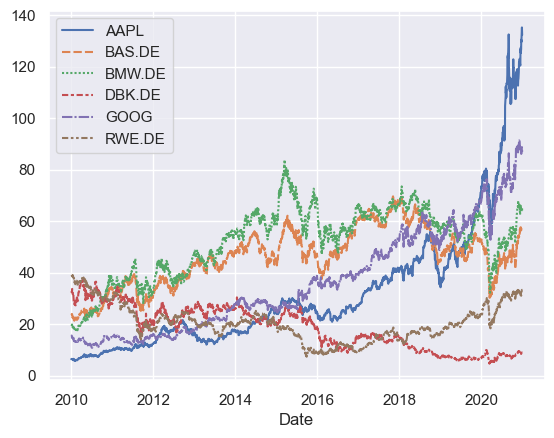

In [94]:
sns.lineplot(data = data);

In [95]:
data = pd.DataFrame(np.diff(np.log(data[1:]), axis=0) * 100, columns=data.columns)

In [96]:
data.head()

,AAPL,BAS.DE,BMW.DE,DBK.DE,GOOG,RWE.DE
0,0.172757,-1.527784,0.807971,1.600661,-0.441336,-0.640094
1,-1.603439,0.631936,1.535651,-1.051189,-2.553194,-0.189908
2,-0.185048,-0.665894,0.879996,0.449091,-2.355478,-0.424948
3,0.662632,-0.306197,-1.353533,3.578298,1.324303,-0.146938
4,-0.886054,-1.119392,-1.496368,-1.210318,-0.151272,1.169604


In [97]:
data = data.dropna(axis=0)

In [98]:
for i in range(0, data.shape[1]):
    data.iloc[:, i] = data.iloc[:, i][data.iloc[:, i].between(data.iloc[:, i].quantile(0.05), data.iloc[:, i].quantile(0.95))]

In [99]:
data = data.dropna(axis = 0)

In [100]:
data.head()

,AAPL,BAS.DE,BMW.DE,DBK.DE,GOOG,RWE.DE
0,0.172757,-1.527784,0.807971,1.600661,-0.441336,-0.640094
2,-0.185048,-0.665894,0.879996,0.449091,-2.355478,-0.424948
3,0.662632,-0.306197,-1.353533,3.578298,1.324303,-0.146938
4,-0.886054,-1.119392,-1.496368,-1.210318,-0.151272,1.169604
6,1.400719,0.936526,0.606481,-1.693974,-0.575764,-0.220499


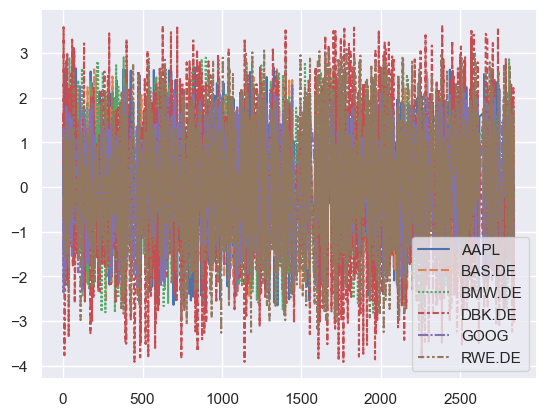

In [101]:
sns.lineplot(data = data);

<AxesSubplot:ylabel='AAPL'>

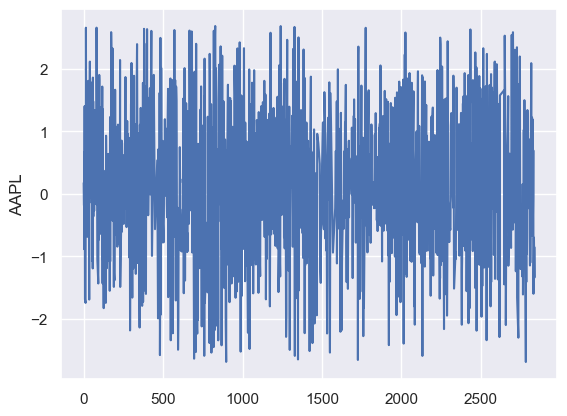

In [102]:
sns.lineplot(data = data.AAPL)

In [103]:
mu = np.mean(data)
Cov = np.cov(data, rowvar=0)
C1 = np.linalg.inv(Cov)

c:\Users\morit\anaconda3\envs\myenv\lib\site-packages\numpy\core\fromnumeric.py:3472: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


In [104]:
a = mu[np.newaxis, :] * C1 * mu[np.newaxis, :]
b = np.ones([1,6])[np.newaxis, :] * C1 *  mu[np.newaxis, :]
d = np.ones([1,6])[np.newaxis, :] * C1 *  np.ones([1,6])[np.newaxis, :]

C:\Users\morit\AppData\Local\Temp\ipykernel_11188\896987765.py:1: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  a = mu[np.newaxis, :] * C1 * mu[np.newaxis, :]
C:\Users\morit\AppData\Local\Temp\ipykernel_11188\896987765.py:2: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  b = np.ones([1,6])[np.newaxis, :] * C1 *  mu[np.newaxis, :]


In [130]:
w = np.random.random([10000,6])


In [131]:
for i in range(0, 10000):
    w[i] = w[i] / w[i].sum()

In [132]:
returns_aapl = w[0:]

In [133]:
w[0,0] * data.iloc[0,0]

0.035113528747233724

In [134]:
returns_test = np.empty_like(w)

In [142]:
for i in range(0, 10000):
    for j in range(0, data.shape[1]):
        returns_test[i,j] = w[i,j] * data.iloc[i,j]

IndexError: index 1692 is out of bounds for axis 0 with size 1692

In [ ]:
returns_mean = returns_test.mean(axis=1)
returns_std = returns_test.std(axis = 1)

In [136]:
results = pd.DataFrame([returns_mean, returns_std]).T


In [137]:
results.columns = ["mean", "std"]

In [138]:
results.head()

,mean,std
0,0.007589,0.139660
1,-0.150057,0.264456
2,0.058582,0.255152
3,-0.151360,0.149718
4,0.017175,0.181734


In [139]:
results.shape

(1000, 2)

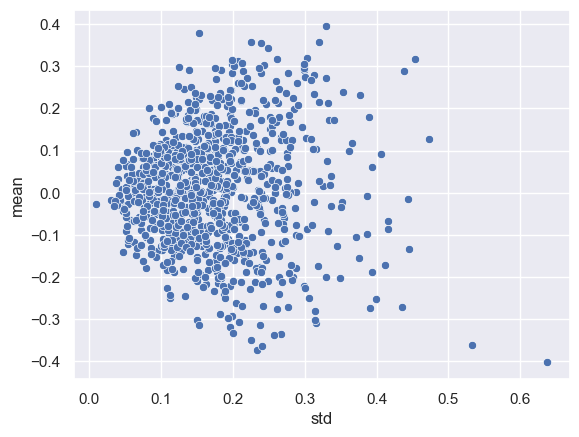

In [140]:
sns.scatterplot(y = results["mean"], x = results["std"]);

In [141]:
data.shape

(1692, 6)